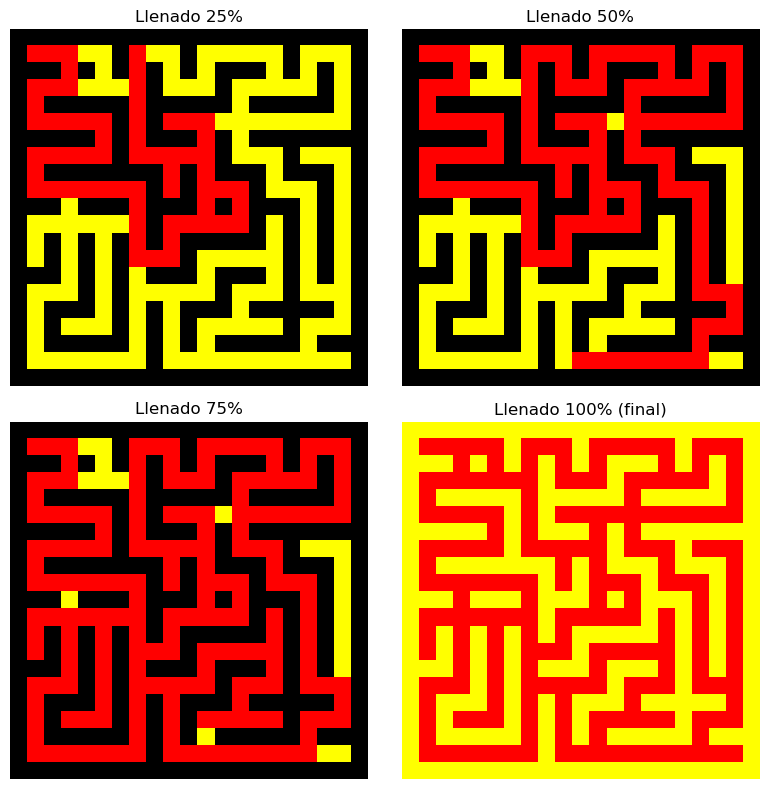

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
from heapq import heappush, heappop
from matplotlib.colors import ListedColormap

import copy
from collections import deque
np.random.seed(42); random.seed(42)

def generar_laberinto_conectado(filas, columnas):
    if filas % 2 == 0: filas += 1
    if columnas % 2 == 0: columnas += 1
    laberinto = [['1' for _ in range(columnas)] for _ in range(filas)]
    visitado = [[False for _ in range(columnas)] for _ in range(filas)]
    def vecinos(x, y):
        dirs = [(-2,0),(2,0),(0,-2),(0,2)]
        result = []
        for dx, dy in dirs:
            nx, ny = x+dx, y+dy
            if 0 <= nx < filas and 0 <= ny < columnas and not visitado[nx][ny]:
                result.append((nx, ny))
        random.shuffle(result)
        return result
    def dfs(x, y):
        visitado[x][y] = True
        laberinto[x][y] = '0'
        for nx, ny in vecinos(x, y):
            if not visitado[nx][ny]:
                laberinto[(x+nx)//2][(y+ny)//2] = '0'
                dfs(nx, ny)
    start_x, start_y = 1, 1
    if start_x < filas and start_y < columnas:
        dfs(start_x, start_y)
    for i in range(3, filas-1, 4):
        for j in range(3, columnas-1, 4):
            if random.random() < 0.3:
                if i > 0 and laberinto[i-1][j] == '1':
                    laberinto[i-1][j] = '0'
                elif j > 0 and laberinto[i][j-1] == '1':
                    laberinto[i][j-1] = '0'
    return laberinto

# ================== DIBUJADO ==================
# mapa: 0=blanco (libre no visitado), 1=negro (pared), 2=gris (visitado)
from matplotlib.colors import ListedColormap
cmap = ListedColormap([[1,1,1], [0,0,0], [0.6,0.6,0.6]])  # 0=blanco, 1=negro, 2=gris

def to_numeric_grid(lab):
    h, w = len(lab), len(lab[0])
    M = np.zeros((h, w), dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            M[i, j] = 1 if lab[i][j] == '1' else 0
    return M
from matplotlib.colors import ListedColormap
cmap = ListedColormap([[1,1,0], [0,0,0], [1,0,0]])  # 0=negro, 1=blanco, 2=rojo
def draw_state(ax, base_grid, visited_set, title):
    h, w = base_grid.shape
    img = np.zeros((h, w), dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if base_grid[i, j] == 1:
                img[i, j] = 1  # muro (blanco)
            elif (i, j) in visited_set and base_grid[i, j] == 0:
                img[i, j] = 2  # camino visitado (rojo)
            else:
                img[i, j] = 0  # fondo (negro)
    ax.imshow(img, cmap=cmap, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')

# ================== A* ==================
def astar(grid, start, goal):
    """grid: 0 libre, 1 pared. start, goal: (r,c). Retorna lista de celdas desde start a goal (incluidas) o [] si no hay camino."""
    if start == goal:
        return [start]
    h, w = grid.shape
    def hfun(a, b):  # Manhattan
        return abs(a[0]-b[0]) + abs(a[1]-b[1])
    open_heap = []
    heappush(open_heap, (hfun(start, goal), 0, start))
    came = {}
    g = {start: 0}
    open_set = {start}
    while open_heap:
        _, gcur, cur = heappop(open_heap)
        if cur == goal:
            # reconstruir
            path = [cur]
            while cur in came:
                cur = came[cur]
                path.append(cur)
            path.reverse()
            return path
        open_set.discard(cur)
        r, c = cur
        for dr, dc in ((1,0),(-1,0),(0,1),(0,-1)):
            nr, nc = r+dr, c+dc
            if not (0 <= nr < h and 0 <= nc < w): 
                continue
            if grid[nr, nc] == 1: 
                continue
            ng = gcur + 1
            nxt = (nr, nc)
            if ng < g.get(nxt, 1<<30):
                came[nxt] = cur
                g[nxt] = ng
                f = ng + hfun(nxt, goal)
                if nxt not in open_set:
                    heappush(open_heap, (f, ng, nxt))
                    open_set.add(nxt)
    return []

# ================== RELLENO USANDO A* ==================
def primera_libre(grid):
    """Primera celda libre (0) escaneando desde arriba-izquierda."""
    h, w = grid.shape
    for i in range(h):
        for j in range(w):
            if grid[i, j] == 0:
                return (i, j)
    return None

def vecinos4(grid, r, c):
    for dr, dc in ((1,0),(-1,0),(0,1),(0,-1)):
        nr, nc = r+dr, c+dc
        if 0 <= nr < grid.shape[0] and 0 <= nc < grid.shape[1]:
            yield (nr, nc)

def fill_all_with_astar(grid):
    """Expansión tipo ‘frente de onda’ pero moviéndose con A* hacia la siguiente celda frontera."""
    start = primera_libre(grid)
    if start is None:
        return [], set()
    libres_total = int(np.sum(grid == 0))
    visited = set([start])
    cur = start
    # frontera: celdas libres adyacentes a visitadas y aún no visitadas
    def recompute_frontier():
        F = set()
        for (r, c) in visited:
            for (nr, nc) in vecinos4(grid, r, c):
                if grid[nr, nc] == 0 and (nr, nc) not in visited:
                    F.add((nr, nc))
        return F

    frontier = recompute_frontier()

    # puntos de captura para 3 impresiones (~30%, ~60%, ~90%)
    milestones = [int(libres_total*0.3), int(libres_total*0.6), int(libres_total*0.9)]
    snapshots = []  # lista de sets de visitados (copias) cuando se alcanza cada hito

    while len(visited) < libres_total and frontier:
        # seleccionar celda de frontera más cercana a cur por Manhattan
        goal = min(frontier, key=lambda p: abs(p[0]-cur[0]) + abs(p[1]-cur[1]))
        path = astar(grid, cur, goal)
        if not path:
            # si por alguna razón no hay camino, eliminamos esa frontera
            frontier.discard(goal)
            continue
        # marcar el camino como visitado
        for cell in path:
            visited.add(cell)
        cur = goal
        # actualizar frontera
        frontier = recompute_frontier()

        # guardar snapshots
        while milestones and len(visited) >= milestones[0]:
            snapshots.append(set(visited))  # copia
            milestones.pop(0)

    # si no se completó por frontera vacía, puede haber celdas libres aisladas no alcanzables
    # en un laberinto conectado esto no debería ocurrir
    if len(snapshots) < 3:
        # completar con el último estado disponible para asegurar 3 impresiones
        while len(snapshots) < 3:
            snapshots.append(set(visited))
    return snapshots, visited

# ================== MAIN ==================
lab = generar_laberinto_conectado(20, 20)
base = to_numeric_grid(lab)  # 0 libre, 1 pared

snapshots, visited_final = fill_all_with_astar(base)

fig, axes = plt.subplots(2, 2, figsize=(8,8))
axes = axes.ravel()
draw_state(axes[0], base, snapshots[0], "Llenado 25%")
draw_state(axes[1], base, snapshots[1], "Llenado 50%")
draw_state(axes[2], base, snapshots[2], "Llenado 75%")
draw_state(axes[3], base, visited_final, "Llenado 100% (final)")
plt.tight_layout()
plt.show()